In [1]:
# Import modules and packages
import numpy as np
import problemLibrary as pl
import os
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, Aer, execute

degree = 3 # degree of graph
rounds = 1 # number of rounds

# Load the fixed angles from angles_regular_graphs.json taken from https://github.com/danlkv/fixed-angle-QAOA
angle_data = pl.fixed_angles_data[str(degree)][str(rounds)]
betas = angle_data['beta']
gammas = angle_data['gamma']
guarantee = angle_data['AR']

In [2]:
def create_QAOA_circuit(nodes, edges, betas, gammas):
    assert len(betas) == len(gammas), "Betas and Gammas arrays should be of the same length"
    rounds = len(betas)
    circuit = QuantumCircuit(nodes)
    for i in range(nodes):
        # Apply the Hadamard gate on each qubit
        circuit.h(i)

    for roundIndex in range(rounds):
        # For each round, apply RZZ gates followed by RX gates
        beta = betas[roundIndex]
        gamma = gammas[roundIndex]

        for i,j in edges:
            # exp(i gamma/2 Z_i Z_j)
            circuit.rzz( -gamma, i, j)
        for i in range(nodes):
            # exp(-i beta X_i)
            circuit.rx(2 * beta, i)
    
    return circuit


def get_QAOA_approxRatio(size, betas, gammas):
    """
    Obtain the approximation ratio using a state vector simulator, for a graph of given size (and degree 3; load from the problemLibrary), and with the given angles
    """
    # Load the problem
    nodes, edges = pl.read_maxcut_instance(size)
    optVal, solution = pl.read_maxcut_solution(size)
    # Create QAOA circuit
    circuit = create_QAOA_circuit(nodes, edges, betas, gammas)

    # Obtain probabilities using state vector simulation 
    sv = Aer.get_backend('statevector_simulator')
    sv_counts = execute(circuit, sv).result().get_counts()
    
    # Get energy expectation value
    ee = 0
    for (cut, count) in sv_counts.items():
        size = pl.eval_cut(nodes, edges, cut)
        ee = ee + size * count
    
    # Get approximation ratio
    ar = ee / optVal

    return ar    

In [3]:
size_list = list(range(4,17,2))
ar_list = [get_QAOA_approxRatio(size,betas, gammas) for size in size_list]

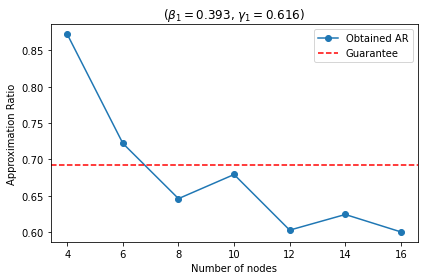

In [4]:
plt.plot(size_list, ar_list, '-o', label='Obtained AR')
plt.axhline(y=guarantee, ls='--', c='r', label='Guarantee')
angle_str = ""
for ind in range(rounds):
    angle_str += r"($\beta_{}={:.3f}$,".format(ind + 1, betas[ind])
    angle_str += r" $\gamma_{}={:.3f}$) ".format(ind + 1, gammas[ind]) + "\n"
angle_str = angle_str[:-2]
plt.title(angle_str)
plt.xlabel("Number of nodes")
plt.ylabel("Approximation Ratio")
plt.legend()
plt.tight_layout()
plt.savefig("Rounds={}.png".format(rounds))


#### Do a parameter sweep for rounds=1 and for a specified problem size. Plot the results as a pseudocolor map 

In [41]:
# Parameter sweep for a particular problem size
# betas lie in [0,pi]
# gammas lie in [0,2pi]
size = 6
numpts = 50
_betas = np.linspace(0, np.pi, numpts)
_gammas = np.linspace(0, 2 * np.pi, numpts)
betas_arr, gammas_arr = np.meshgrid(_betas, _gammas)
ar_arr = np.zeros(betas_arr.shape)
for indx in range(numpts):
    for indy in range(numpts):
        beta = [betas_arr[indx, indy]]
        gamma = [gammas_arr[indx, indy]]
        ar_arr[indx, indy] = get_QAOA_approxRatio(size, beta, gamma)
fixed_beta, fixed_gamma = pl.fixed_angles_data["3"]["1"]['beta'], pl.fixed_angles_data["3"]["1"]['gamma']
fixed_AR = get_QAOA_approxRatio(size, fixed_beta, fixed_gamma)

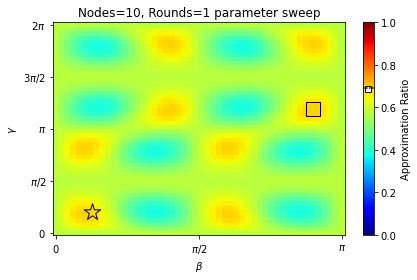

In [ ]:
import matplotlib.cm as cm
cmap = cm.get_cmap('jet')
fig, ax = plt.subplots()
# Colormap from the parameter sweep
cc = ax.pcolor(betas_arr, gammas_arr, ar_arr, vmin = 0, vmax = 1, cmap=cmap)
# Plot the AR obtained for the fixed angle parameters
ax.scatter(fixed_beta, fixed_gamma, c= [cmap(fixed_AR)], s=300, marker = '*', linewidths=1, edgecolors='k', label = "Fixed Angle")
# Plot the best obtained approximation ratio point
maxx, maxy = np.unravel_index(np.argmax(ar_arr), ar_arr.shape)
ax.scatter(betas_arr[maxx,maxy], gammas_arr[maxx,maxy], c= [cmap(ar_arr[maxx,maxy])], s=200, marker = 's', linewidths=1, edgecolors='k', label = "Best AR")
# Mark the AR's obtained at the fixed angles, the highest obtained AR, and the guarantee on the colorbar
guar = pl.fixed_angles_data["3"]["1"]['AR']
cbar = plt.colorbar(cc); cbar.set_label("Approximation Ratio")
cbar.ax.plot(0.5, fixed_AR, 'w*', mec='k'); cbar.ax.plot(0.5, ar_arr[maxx,maxy] , c='w', marker='s', mec='k'); cbar.ax.plot([0,1], [guar,guar] , c='k', ls=(0,(1,1)), mec='k')
# Labels, etc.
ax.set_title("Nodes={}, Rounds=1 parameter sweep".format(size))
ax.set_xlabel(r"$\beta$")
ax.set_ylabel(r"$\gamma$")
ax.set_xticks([0, np.pi/2, np.pi], labels=["$0$", r"$\pi/2$", r'$\pi$'])
ax.set_yticks([0, np.pi/2, np.pi, np.pi*1.5, np.pi *2], labels=["$0$", r"$\pi/2$", r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
plt.tight_layout()
plt.savefig("Sweep-Size={}-Rounds={}.png".format(size, 1))